In [8]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import os

from helpers import (
    get_hurricane_bin_midpoint_times,
    get_hurricane_bin_start_times,
    get_hurricane_bin_end_times
)

In [9]:
# Get all hurricane information
all_hurricanes = pd.read_csv("data/global/hurricane/atl_hurricane_list_20210101_20231231.csv")

In [10]:
def pull_hurricane_data(hurricane_name):
    # Select specific hurricane and pull corresponding data
    specific_hurricane = all_hurricanes[all_hurricanes['name'] == hurricane_name]
    hurricane_code = specific_hurricane['code'].values[0]
    hurricane_year = specific_hurricane['year'].values[0]

    glm_df = pd.read_csv(f"data/storms/{hurricane_name}_{hurricane_year}/glm/groups.csv", parse_dates=['Group Time'])
    best_track_df = pd.read_csv(f'data/storms/{hurricane_name}_{hurricane_year}/hurricane/besttrack.csv', parse_dates=['Timestamp'])
    return hurricane_code, hurricane_year, glm_df, best_track_df


In [11]:
hurricane_name = "IAN"
hurricane_code, hurricane_year, glm_df, best_track_df = pull_hurricane_data(hurricane_name)

In [12]:
glm_df

,Group Time,Group Latitude,Group Longitude,Group Area,Group Energy,Group Quality Flag,Distance From Hurricane Center (m),Direction from Hurricane Center (deg)
0,2022-09-22 18:00:01.496429,8.041265,-71.181946,858,77,0,711443.129786,228.700792
1,2022-09-22 18:00:01.498337,8.058331,-71.181780,429,64,0,710163.990702,228.812909
2,2022-09-22 18:00:01.500626,8.044061,-71.181890,858,91,0,711231.318222,228.718974
3,2022-09-22 18:00:01.502533,8.058308,-71.181755,429,60,0,710163.883086,228.812614
4,2022-09-22 18:00:01.504440,8.058308,-71.181750,429,26,0,710163.258572,228.812568
...,...,...,...,...,...,...,...,...
8900892,2022-10-01 05:59:34.450378,36.649746,-74.220140,432,13,0,516241.054960,71.063556
8900893,2022-10-01 05:59:34.462204,36.725376,-74.219220,432,12,0,518657.097142,70.172543
8900894,2022-10-01 05:59:34.506073,36.801200,-74.249810,866,105,0,518522.784658,69.194160
8900895,2022-10-01 05:59:34.507980,36.801200,-74.249430,866,83,0,518555.233282,69.195299


In [13]:
best_track_df

,Timestamp,Status,Latitude,Longitude,Storm Motion Direction (deg),Maximum Sustained Winds,Minimum Pressure,Radius of Maximum Winds
0,2022-09-22 18:15:00,LO,12.3250,-66.337500,304.146556,30,1006,70
1,2022-09-22 18:45:00,LO,12.3750,-66.412500,304.151738,30,1006,70
2,2022-09-22 19:15:00,LO,12.4250,-66.487500,304.156942,30,1006,70
3,2022-09-22 19:45:00,LO,12.4750,-66.562500,304.162168,30,1006,70
4,2022-09-22 20:15:00,LO,12.5250,-66.637500,304.167415,30,1006,70
...,...,...,...,...,...,...,...,...
403,2022-10-01 03:45:00,EX,34.9625,-79.550000,339.912834,30,999,180
404,2022-10-01 04:15:00,EX,35.0375,-79.583333,339.929944,30,999,180
405,2022-10-01 04:45:00,EX,35.1125,-79.616667,339.947090,30,999,180
406,2022-10-01 05:15:00,EX,35.1875,-79.650000,339.964271,30,999,180


In [14]:
# initialize radius and bin times 
bin_times = get_hurricane_bin_midpoint_times(hurricane_code, region="atl", time_interval=30)
bin_starts = get_hurricane_bin_start_times(hurricane_code, region="atl", time_interval=30)
bin_ends = get_hurricane_bin_end_times(hurricane_code, region="atl", time_interval=30)

In [15]:
def nautical_miles_to_meters(nautical_miles):
    """
    Converts a distance in nautical miles to meters.

    Args:
        nautical_miles (float or int): The distance in nautical miles.

    Returns:
        float: The equivalent distance in meters.
    """
    conversion_factor = 1852
    meters = nautical_miles * conversion_factor
    return meters


In [21]:
# Get lightning group counts for each bin of histogram
lightning_groups_inner_core = []
lightning_groups_outer_core = []

for idx in range(len(bin_times)):
    bin_time = bin_times[idx]
    #print(bin_time)
    bin_start = bin_starts[idx]
    bin_end = bin_ends[idx]

    try:
        # get RMW at bin time
        rmw_nautical = best_track_df[best_track_df['Timestamp'] == bin_time]['Radius of Maximum Winds'].values[0]
        rmw_meters = nautical_miles_to_meters(rmw_nautical)
        inner_core_filter = 1.5*rmw_meters
        outer_core_filter = 5*rmw_meters
        # filter bin time
        filter_glm_data = glm_df[(glm_df["Group Time"] >= bin_start) & (glm_df["Group Time"] < bin_end)]
        # filter data to only include lightning within 400 km of hurricane center
        filter_glm_data_inner_core = filter_glm_data[filter_glm_data["Distance From Hurricane Center (m)"] <= inner_core_filter]
        filter_glm_data_outer_core = filter_glm_data[(filter_glm_data["Distance From Hurricane Center (m)"] > inner_core_filter) & (filter_glm_data["Distance From Hurricane Center (m)"] <= outer_core_filter)]
        num_groups_inner_core = len(filter_glm_data_inner_core)
        num_groups_outer_core = len(filter_glm_data_outer_core)
        #print(num_groups)
        lightning_groups_inner_core.append([bin_time,num_groups_inner_core])
        lightning_groups_outer_core.append([bin_time,num_groups_outer_core])
    except:
        print('No Lightning')

lightning_groups_inner_core_df = pd.DataFrame(lightning_groups_inner_core, columns=["time", "groups"])
lightning_groups_outer_core_df = pd.DataFrame(lightning_groups_outer_core, columns=["time", "groups"])

In [24]:
def create_histogram(lightning_groups_inner_core_df,lightning_groups_outer_core_df,best_track_df,hurricane_name,hurricane_year):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
    fig.suptitle(f"{hurricane_name} {hurricane_year}: GLM Groups", fontsize=16)

    # Helper to draw one panel
    def plot_panel(ax, lightning_df, title):
        # Left axis: GLM group count
        ax.bar(
            lightning_df['time'],
            lightning_df['groups'],
            width=0.03,
            color='tab:blue',
            label='GLM Groups'
        )
        ax.set_title(title)
        ax.set_ylabel('Group Count')
        ax.tick_params(axis='x', labelrotation=90)

        # Right axis 1: Pressure
        ax_r1 = ax.twinx()
        ax_r1.plot(
            best_track_df['Timestamp'],
            best_track_df['Minimum Pressure'],
            color='tab:green',
            linewidth=1,
            label='Pressure (mb)'
        )
        ax_r1.set_ylim(825, 1025)
        ax_r1.set_ylabel('Pressure (mb)', color='tab:green')

        # Right axis 2: Wind speed
        ax_r2 = ax.twinx()
        ax_r2.plot(
            best_track_df['Timestamp'],
            best_track_df['Maximum Sustained Winds'],
            color='tab:red',
            linewidth=1,
            label='Sustained Wind (knots)'
        )
        ax_r2.set_ylim(0, 200)
        ax_r2.set_ylabel('Sustained Wind (knots)', color='tab:red')
        ax_r2.spines['right'].set_position(('outward', 60))

        # Combined legend
        lines, labels = [], []
        for a in [ax, ax_r1, ax_r2]:
            l, lab = a.get_legend_handles_labels()
            lines.extend(l)
            labels.extend(lab)
        ax.legend(lines, labels, loc='best')

    # Left subplot: Inner core
    plot_panel(axes[0], lightning_groups_inner_core_df, "r <= 1.5RMW")

    # Right subplot: Outer core
    plot_panel(axes[1], lightning_groups_outer_core_df, "1.5RMW < r <= 5RMW")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


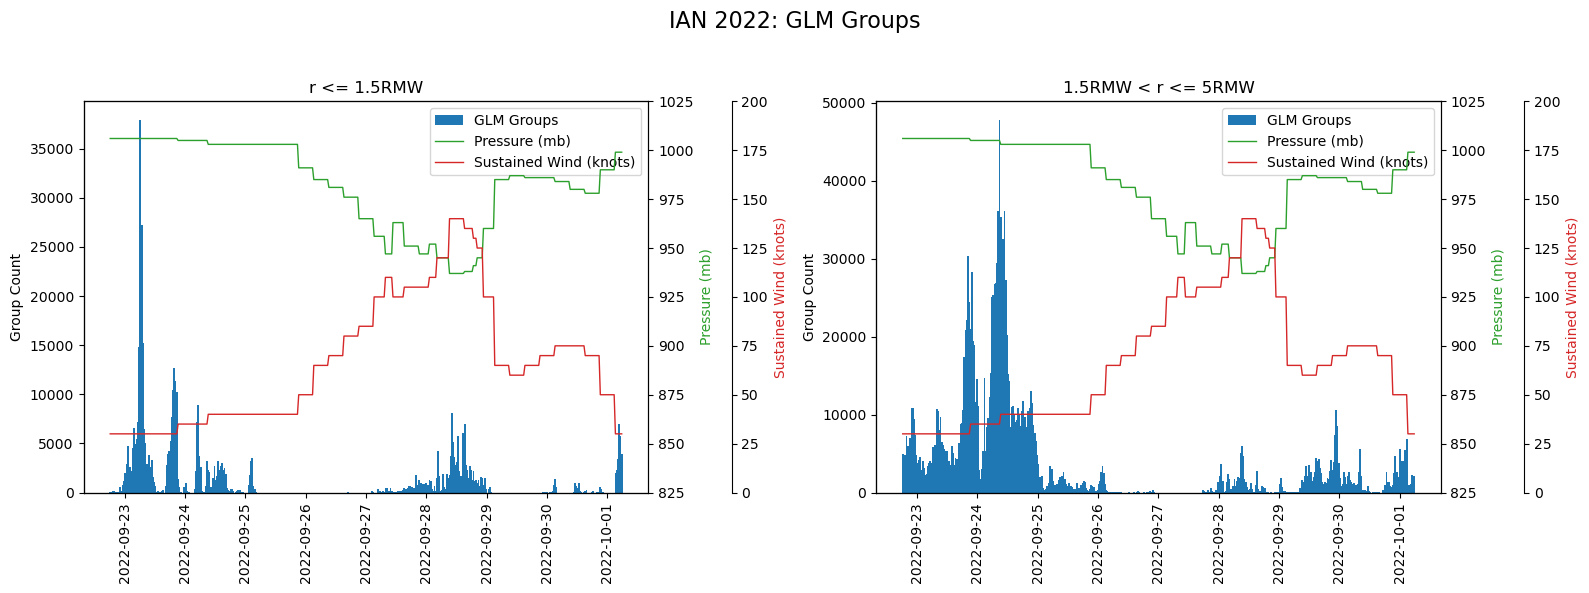

In [25]:
create_histogram(lightning_groups_inner_core_df,lightning_groups_outer_core_df,best_track_df,hurricane_name,hurricane_year)

In [ ]:
# # Pull more glm data
# from helpers import process_glm_info_for_hurricane

# # Process GLM data for a single hurricane
# csv_path = process_glm_info_for_hurricane(
#     "AL022022",  # Hurricane code
#     box_size=6,  # Size of lat/lon box in degrees
#     region="atl",
#     time_interval=30,
#     cache_dir=None  # Uses default cache directory
# )
# # Saves to data/storms/IAN_2022/glm/groups.csv

Loaded best track data from data/global/hurricane/atl_all_hurricane_best_tracks_20210101_20231231.csv
Saved interpolated best track data to data/storms/BONNIE_2022/hurricane/besttrack.csv
Processing GLM data for BONNIE (AL022022)...
  Time range: 2022-06-27 18:00:00 to 2022-07-11 00:00:00
  Number of bins: 636
Found 57419 GLM URLs in total
  Found 57239 GLM URLSs within hurricane time range
  Processing bin 1/636: 2022-06-27 18:15:00
    Getting GLM URLs for bin 2022-06-27 18:15:00...
    Aggregating GLM data from 90 files...
    Found 410 lightning groups
  Processing bin 2/636: 2022-06-27 18:45:00
    Getting GLM URLs for bin 2022-06-27 18:45:00...
    Aggregating GLM data from 90 files...
    Found 462 lightning groups
  Processing bin 3/636: 2022-06-27 19:15:00
    Getting GLM URLs for bin 2022-06-27 19:15:00...
    Aggregating GLM data from 90 files...
    Found 113 lightning groups
  Processing bin 4/636: 2022-06-27 19:45:00
    Getting GLM URLs for bin 2022-06-27 19:45:00...
   

## Old Code
### Used for single plot at a time

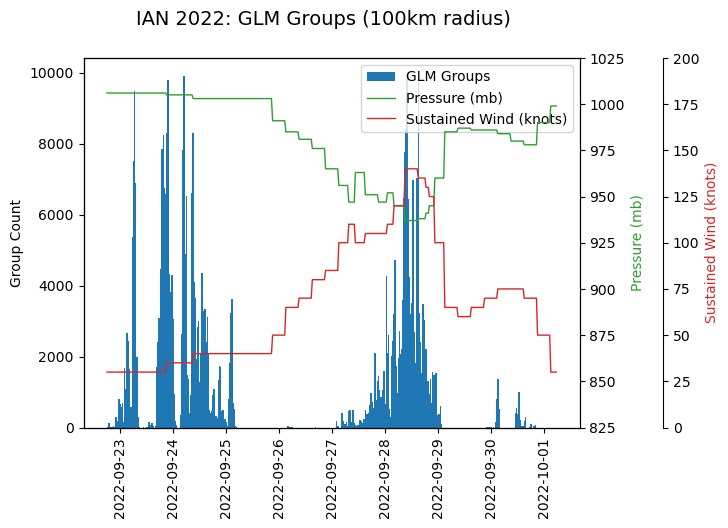

In [46]:
fig, ax = plt.subplots()

fig.suptitle(f"{hurricane_name} {hurricane_year}: GLM Groups", fontsize=14)

# Left axis: group count
ax.bar(
    lightning_groups_inner_core_df['time'], ## change to be lightning_groups_rainbands_df when desired 
    lightning_groups_inner_core_df['groups'],  ## change to be lightning_groups_rainbands_df when desired 
    width=0.03,          # tune based on time resolution
    color='tab:blue',
    label='GLM Groups'
)
ax.set_ylabel('Group Count')
ax.tick_params(axis='y')
ax.tick_params(axis='x', labelrotation=90)

# Right axis 1: pressure
ax_r1 = ax.twinx()
ax_r1.plot(
    best_track_df['Timestamp'],
    best_track_df['Minimum Pressure'],
    color='tab:green',
    label='Pressure (mb)',
    linewidth=1
)
ax_r1.set_ylim(825, 1025)
ax_r1.set_ylabel('Pressure (mb)', color='tab:green')
ax_r1.tick_params(axis='y')

# Right axis 2: wind speed
ax_r2 = ax.twinx()
ax_r2.plot(
    best_track_df['Timestamp'],
    best_track_df['Maximum Sustained Winds'],
    color='tab:red',
    label='Sustained Wind (knots)',
    linewidth=1
)
ax_r2.set_ylim(0, 200)
ax_r2.set_ylabel('Sustained Wind (knots)', color='tab:red')
ax_r2.tick_params(axis='y')
ax_r2.spines['right'].set_position(('outward', 60))

lines = []
labels = []

for a in [ax, ax_r1, ax_r2]:
    l, lab = a.get_legend_handles_labels()
    lines.extend(l)
    labels.extend(lab)

ax.legend(lines, labels, loc='best')


plt.show()